  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 1


  1%|▋                                                                                 | 1/128 [00:00<00:18,  7.01it/s]

Epoch 2


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 3


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 4


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 5


  1%|▋                                                                                 | 1/128 [00:00<00:22,  5.76it/s]

Epoch 6


  1%|▋                                                                                 | 1/128 [00:00<00:23,  5.48it/s]

Epoch 7


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 8


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 9


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:27<00:00,  4.63it/s]


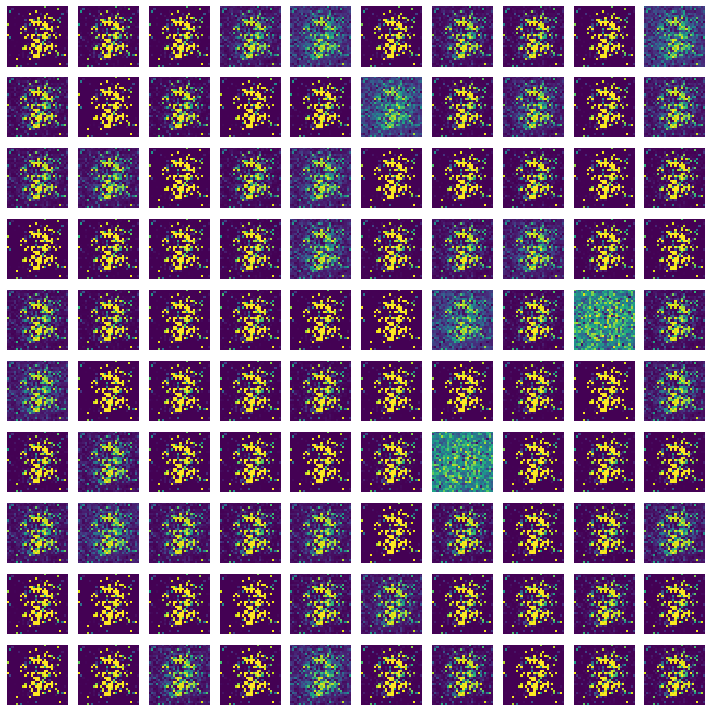

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import tensorflow as tf

def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    ## structure of model
    from keras.utils import plot_model
    plot_model(generator, show_shapes=True, to_file='generator.png')
    
    plot_model(discriminator, show_shapes=True, to_file='discriminator.png')
    
    plot_model(gan, show_shapes=True, to_file='gan.png')
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        # Generate random noise as an input to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            # Pretrain discriminator on  fake and real data before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            y_gen = np.ones(batch_size)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            # Training  the GAN by alternating the training of the Discriminator and training the chained GAN model with Discriminator's weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           plot_generated_images(e, generator)
        
training(10,128)